# Causal Discovery under Causal Sufficiency

In certain case, it is reasonable to assume that there are no latent confounders and no selection bias.
In this case, we assume that given a dataset, the true underlying causal diagram, over the measured variables,
is a directed acyclic graph (DAG).

A common algorithm used in these cases is the PC algorithm (named after its inventors Peter Spirtes and Clark Glymour).
An efficient algorithm is the recursive autonomy identification (RAI) algorithm.
In the large sample limit, both algorithms a proved to recover the equivalence class of the true underlying DAG.
This equivalence class is called completed partially directed graph (CPDAG), or essential graph.

For demonstrating PC and RAI, we follow these steps.

Initially, the required classes and methods are imported.

In [139]:
import sys
sys.path.append('..')

import numpy as np
from causal_discovery_utils.cond_indep_tests import CondIndepCMI
from causal_discovery_algs import LearnStructRAI, LearnStructPC
from causal_discovery_utils.data_utils import get_var_size
from graphical_models import DAG, PDAG
from causal_discovery_utils.performance_measures import structural_hamming_distance_cpdag, score_bdeu
from experiment_utils.threshold_select_ci_test import search_threshold_bdeu
from matplotlib import pyplot as plt

## Experiment Setup

Firstly, we will use the ALARM monitoring system (Beinlich et al., 1989) as the true underlying graph.
It is a Bayesian network consisting of 37 nodes (8 diagnoses, 16 findings and 13 intermediate variables), and 46 edges.
As an example, we use one dataset sampled from this Bayesian network by Tsamardinos et al. (2006).
The full database they created, covering a range of Bayesian network and a range of datasets size can be found in
the [supplementary material for the max-min hill-climbing (MMHC) algorithm](https://pages.mtu.edu/~lebrown/supplements/mmhc_paper/mmhc_index.html).

## Initialization
Initially, we define the location and file name of the datasets and graph structure.

In [140]:
data_name = 'Alarm1'  # the ALARM monitoring network (Beinlich et at., 1989)
data_size = 500  # dataset size for learning
data_ver = 1  # dataset version

data_folder = '../example_data/' + data_name + '_data/'
test_data_folder = '../example_data/' + data_name + '_testdata/'

## Load Training Data
The training data will be used to learn the underlying graph structure.

In [141]:
data_train = np.loadtxt(data_folder + data_name + '_s' + str(data_size) + '_v' + str(data_ver) + '.txt',
                        dtype=int)
n_samples, n_vars = data_train.shape  # data is assumed a numpy 2d-array
graph_nodes = set(range(n_vars))  # create a set containing the nodes indices

The loaded data, `data_train`, is a 2D numpy array, where its first axis is the sample index
and its second axis is the variable index.

## Learn the Equivalence Class (CPDAG) of the Underlying DAGs

Initially, we set the conditional independence test.
We select the conditional mutual information (CMI) as it is suitable for estimating the level of correlation
between discrete variables (all the variables in the ALARM network are discrete).

In [142]:
CITest = CondIndepCMI  # class of the ci test to be used

In addition, we search the CMI threshold that maximizes the likelihood of the graph.
This strategy was suggested by Yehezkel and Lerner (2009) for the RAI algorithm. We use it here
for the PC algorithm as well. The method that searches for the threshold is `search_threshold_bdeu`.
It utilizes the caching mechanism of the CI test class to search the threshold efficiently.

Set the list of candidate thresholds.

In [143]:
th_range = [i / 10000 + 0.01 for i in range(100)]  # list of candidate thresholds for CI test

Find the threshold for RAI

In [144]:
th_rai, all_scores_rai = search_threshold_bdeu(LearnStructRAI, data_train, CITest, th_range)
print('Selected RAI threshold = {:.4f}'.format(th_rai))

Selected RAI threshold = 0.0159


Find the threshold for PC

In [145]:
th_pc, all_scores_pc = search_threshold_bdeu(LearnStructPC, data_train, CITest, th_range)
print('Selected PC threshold = {:.4f}'.format(th_pc))

Selected PC threshold = 0.0120


## Learn using the RAI algorithm
First, instantiate a CI test with the selected threshold and training dataset

In [146]:
ci_test_rai = CITest(dataset=data_train, threshold=th_rai, count_tests=True)  # conditional independence test

Then, instantiate an RAI learner

In [147]:
rai = LearnStructRAI(nodes_set=graph_nodes, ci_test=ci_test_rai)

Finally, learn the structure

In [148]:
rai.learn_structure()  # learn structure

## Learn using the PC algorithm

Instantiate a CI test and a PC learner, and learn the structure.

In [149]:
ci_test_pc = CITest(dataset=data_train, threshold=th_pc, count_tests=True)  # conditional independence test
pc = LearnStructPC(nodes_set=graph_nodes, ci_test=ci_test_pc)
pc.learn_structure()  # learn structure

## Examine Results

We compare the PC and RAI algorithms using three measures:
1. *Complexity* in terms of the number of CI tests required for learning the graph
2. *Structural Hamming distance* of the learned graph from the true underlying CPDAG
3. *BDeu* score of the learned graph calculated using a novel, large, test dataset

Initially, load the true underlying DAG and calculate its equivalence class CPDAG.

In [150]:
# Load True Graph
true_dag_np = np.loadtxt(data_folder + data_name + '_graph.txt', dtype=int)
true_dag = DAG(graph_nodes)
true_dag.init_from_adj_mat(true_dag_np)
true_cpdag = PDAG(true_dag.nodes_set)
true_dag.convert_to_cpdag(true_cpdag)  # create equivalence class of th true DAG

# Load Test Data
data_test = np.loadtxt(test_data_folder + data_name + '_testdata_s' + str(data_size) + '_v' + str(data_ver) + '.txt', dtype=int)

### Examine the Quality of the Learned Graphs

Calculate the structural Hamming distance of the graphs learned by each of the algorithms

In [151]:
shd_rai = structural_hamming_distance_cpdag(rai.graph, true_cpdag)
shd_pc = structural_hamming_distance_cpdag(pc.graph, true_cpdag)

Then, calculate the Bayesian score of the true graph and the learned graph using the novel test dataset, as well as the score using the training set

In [152]:
score_true_train = score_bdeu(true_dag, data_train, get_var_size(data_train))  # Bayesian score
score_true_test = score_bdeu(true_dag, data_test, get_var_size(data_test))

rai_dag = DAG(rai.graph.nodes_set)
rai.graph.convert_to_dag(rai_dag)
rai_score_train = score_bdeu(rai_dag, data_train, ci_test_rai.node_size)
rai_score_test = score_bdeu(rai_dag, data_test, ci_test_rai.node_size)

pc_dag = DAG(pc.graph.nodes_set)
pc.graph.convert_to_dag(pc_dag)
pc_score_train = score_bdeu(pc_dag, data_train, ci_test_pc.node_size)
pc_score_test = score_bdeu(pc_dag, data_test, ci_test_pc.node_size)

### Print Quality Measures of the Learned Structures

Print Bayesian score of the graphs

In [153]:
print('True graph BDeu: (train/test): \t{:.0f} / {:.0f}'.format(score_true_train, score_true_test))
print('RAI BDeu (train/test):  \t{:.0f} / {:.0f}'.format(rai_score_train, rai_score_test))
print('PC BDeu  (train/test):  \t{:.0f} / {:.0f}'.format(pc_score_train, pc_score_test))

True graph BDeu: (train/test): 	-5060 / -48038
RAI BDeu (train/test):  	-5194 / -49219
PC BDeu  (train/test):  	-5681 / -53806


Print structural hamming distance

In [154]:
def print_shd(shd, alg_name):
    print(alg_name, '\tEdges: extra|missing', shd['edge']['extra'], shd['edge']['missing'],
          '\tOrientation: extra|missing|revered',
          shd['arrowhead']['extra'], shd['arrowhead']['missing'], shd['arrowhead']['reversed'],
          '\tTotal SHD:', shd['total'])

print_shd(shd_rai, 'RAI.')
print_shd(shd_pc, 'PC.')


RAI. 	Edges: extra|missing 6 7 	Orientation: extra|missing|revered 0 3 2 	Total SHD: 18
PC. 	Edges: extra|missing 8 14 	Orientation: extra|missing|revered 0 5 0 	Total SHD: 27


Plot the number of CI tests required by each algorithm

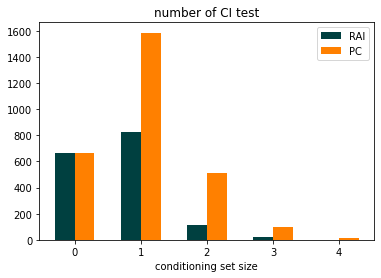

In [155]:
num_ci_order_to_plot = 5
ci_orders = np.array(range(num_ci_order_to_plot), dtype=float)
plt.figure()
plt.bar(ci_orders-0.15, ci_test_rai.test_counter[0:num_ci_order_to_plot], width=0.3, align='center',
        color=[0, 0.25, 0.25])
plt.bar(ci_orders+0.15, ci_test_pc.test_counter[0:num_ci_order_to_plot], width=0.3, align='center',
        color=[1, 0.5, 0])
plt.title('number of CI test')
plt.xlabel('conditioning set size')
plt.legend(['RAI', 'PC'])

plt.show()

---
## References

* Beinlich, Ingo A., Henri Jacques Suermondt, R. Martin Chavez, and Gregory F. Cooper. "The ALARM monitoring system: A case study with two probabilistic inference techniques for belief networks." In AIME 89, pp. 247-256. Springer, Berlin, Heidelberg, 1989.
* Tsamardinos, Ioannis, Laura E. Brown, and Constantin F. Aliferis. "The max-min hill-climbing Bayesian network structure learning algorithm." Machine learning 65, no. 1 (2006): 31-78.
* Yehezkel, Raanan, and Boaz Lerner. "Bayesian Network Structure Learning by Recursive Autonomy Identification." Journal of Machine Learning Research 10, no. 7 (2009).